In [1]:
import arch_1 as arch # This is the model architecture to use
import utils

import tensorflow as tf
import numpy as np
#from tqdm import tqdm, tnrange, tqdm_notebook
import matplotlib.pyplot as plt
%matplotlib inline

/Users/divyayeluri/envs/ml_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/divyayeluri/envs/ml_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/divyayeluri/envs/ml_env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/divyayeluri/envs/ml_env/lib/python3.7/site-packages

# Data Processing

In [2]:
# Parameters to use for the rest of this workflow
BATCH_SIZE = 60
NCLASS = 10

In [3]:
data = np.load("mnist.npz")

In [4]:
# Import and normalize the training and testing data
data = np.load("mnist.npz")
(train_data, train_labels, test_data, test_labels) = data['x_train'], data['y_train'], data['x_test'], data['y_test']
train_data = (train_data - 255 / 2) / 255
test_data = (test_data - 255 / 2) / 255

# Convert labels to one-hot format
train_labels = (np.arange(NCLASS) == train_labels[:, None]).astype(np.float32)
test_labels = (np.arange(NCLASS) == test_labels[:, None]).astype(np.float32)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


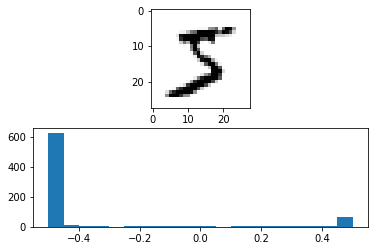

In [5]:
# Sanity check to make sure data is not crazy
plt.subplot(211).imshow(train_data[0], cmap=plt.cm.Greys)
plt.subplot(212).hist(train_data[0].flatten(), bins=20)
print(train_labels[0])

In [6]:
# Extract validation set from data
VAL_SIZE = 5000 #int(train_data.shape[0] * 0.1)
val_data, train_data = train_data[:VAL_SIZE], train_data[VAL_SIZE:]
val_labels, train_labels = train_labels[:VAL_SIZE], train_labels[VAL_SIZE:]

In [7]:
# Reshape data to the format specified by the particular architecture we are using
train_data = arch.reshape_data(train_data)
test_data = arch.reshape_data(test_data)
val_data = arch.reshape_data(val_data)

# Defining computation graph

### Variables and input / output nodes

In [8]:
arch.make_vars_on_cpu(NCLASS)
train_data_node = tf.placeholder(tf.float32, [BATCH_SIZE] + list(train_data.shape[1:]))
train_label_node = tf.placeholder(tf.float32, [BATCH_SIZE, NCLASS])         
test_data_node, test_label_node = tf.constant(test_data, dtype=tf.float32), tf.constant(test_labels, dtype=tf.float32)
val_data_node, val_label_node = tf.constant(val_data, dtype=tf.float32), tf.constant(val_labels, dtype=tf.float32)

### Losses, learning rate, and optimization step

In [9]:
val_out = arch.model(val_data_node)
val_probs = tf.nn.softmax(val_out)

test_out = arch.model(test_data_node)
test_probs = tf.nn.softmax(test_out)

logits, regularizers = arch.model(train_data_node, train=True)
probs = tf.nn.softmax(logits)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=train_label_node))
loss += regularizers

global_step = tf.Variable(0, trainable=False)
start_eta = 0.01
learning_rate = tf.train.exponential_decay(start_eta, global_step * BATCH_SIZE, train_labels.shape[0], 0.95, staircase=True)
update_weights = tf.train.MomentumOptimizer(learning_rate=learning_rate, momentum=0.9).minimize(loss, global_step=global_step)

W0816 05:13:52.205307 140735986992000 deprecation.py:323] From <ipython-input-9-f918e3f1eef6>:9: softmax_cross_entropy_with_logits (from tensorflow.python.ops.nn_ops) is deprecated and will be removed in a future version.
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



# Training

In [10]:
sess = tf.InteractiveSession()
sess.as_default()
tf.global_variables_initializer().run()

### Sanity check, ensure that things are working

Initial mini-batch err: 93.33333333333333


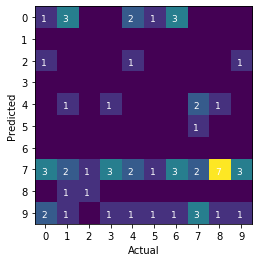

In [11]:
dat, lab = train_data[:BATCH_SIZE], train_labels[:BATCH_SIZE]

feed_dict = {train_data_node:dat, train_label_node:lab }
_, predictions, l = sess.run([update_weights, probs, loss], feed_dict)

err, confusions = utils.error_rate(predictions, lab), utils.confusions(predictions, lab)
print(f"Initial mini-batch err: {err}")
utils.plot_confusions(confusions);

### Actual training

In [12]:
# Train over the first 1/4th of our training set.
n_epoch = 1
steps = (train_labels.shape[0] // BATCH_SIZE) * n_epoch
ls = np.empty(steps)
errs = np.empty(steps)
val_errs = np.empty(np.ceil(steps / 100).astype(int))

for step in range(steps):
    # Compute the offset of the current minibatch in the data.
    offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE) # Should really randomize some
    batch_data = train_data[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE)]
    feed_dict = {train_data_node: batch_data,
                 train_label_node: batch_labels}
    # Run the graph and fetch some of the nodes.
    _, l, predictions = sess.run(
      [update_weights, loss, probs],
      feed_dict=feed_dict)
    ls[step] = l
    errs[step] = utils.error_rate(predictions, batch_labels)
    
    if step % 100 == 0:
        val_errs[step // 100] = utils.error_rate(val_out.eval(), val_labels)
        print('Step %d of %d' % (step, steps))
        print("Mini-batch loss: {}, error: {}, val error: {}".format(ls[step], errs[step], val_errs[step // 100]))

Step 0 of 916
Mini-batch loss: 7.712627410888672, error: 91.66666666666666, val error: 88.94
Step 100 of 916
Mini-batch loss: 3.3196067810058594, error: 8.333333333333337, val error: 6.020000000000003
Step 200 of 916
Mini-batch loss: 3.351055860519409, error: 9.999999999999998, val error: 3.8599999999999968
Step 300 of 916
Mini-batch loss: 3.155623197555542, error: 3.3333333333333326, val error: 3.1399999999999983
Step 400 of 916
Mini-batch loss: 3.1326558589935303, error: 6.666666666666665, val error: 2.62
Step 500 of 916
Mini-batch loss: 3.028395175933838, error: 1.6666666666666718, val error: 2.3800000000000043
Step 600 of 916
Mini-batch loss: 3.054330348968506, error: 5.000000000000004, val error: 1.9399999999999973
Step 700 of 916
Mini-batch loss: 3.11600399017334, error: 6.666666666666665, val error: 2.300000000000002
Step 800 of 916
Mini-batch loss: 3.0401999950408936, error: 6.666666666666665, val error: 1.8199999999999994
Step 900 of 916
Mini-batch loss: 2.8527944087982178, er

# Evaluation

### Performance on test set

Test error: 1.849999999999996


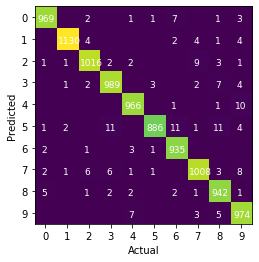

In [13]:
predicted, actual = test_probs.eval(), test_label_node.eval()
error = utils.error_rate(predicted, actual)
confusions = utils.confusions(predicted, actual)
print(f"Test error: {error}")
utils.plot_confusions(confusions);

### Learning curves

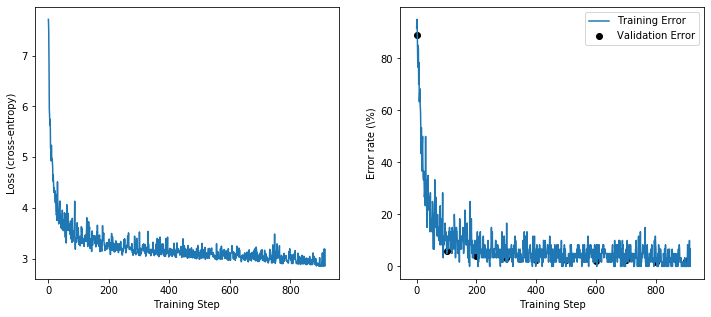

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].plot(ls)
ax[0].set_xlabel("Training Step")
ax[0].set_ylabel("Loss (cross-entropy)")

ax[1].plot(errs, label="Training Error")
ax[1].scatter(np.arange(val_errs.shape[0]) * 100, val_errs, label="Validation Error", c='k')
ax[1].set_xlabel("Training Step")
ax[1].set_ylabel("Error rate (\%)")
ax[1].legend();